In [42]:
# Calling the Functions from desired Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing .text import Tokenizer
from tensorflow.keras.layers import Dense,Activation,Bidirectional,Input,Embedding,LSTM
from tensorflow.keras.models import Model  

In [57]:
# Calling the Dataset
df = pd.read_csv(r"D:\Visual Studio Code\ML\DataSet\Language Translation\English-Hindi Language\hindi_english_parallel.csv")
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [58]:
# Checking the Len of Dataset
len(df)

1561841

In [59]:
# Checking for Null Values
df.isnull().sum()

hindi      6057
english     877
dtype: int64

In [60]:
# Droping the Null value and Removing that row 
df.dropna(inplace=True)
data = df.reset_index(drop=True)

In [61]:
# Checking for null values again 
df.isnull().sum()

hindi      0
english    0
dtype: int64

In [62]:
# Checking the number of data decrease
len(df)

1555574

In [63]:
# Viewing the English Col in Data
df['english']

0             Give your application an accessibility workout
1                          Accerciser Accessibility Explorer
2             The default plugin layout for the bottom panel
3                The default plugin layout for the top panel
4             A list of plugins that are disabled by default
                                 ...                        
1561835                  शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1561836    स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1561837    है। I note that this is a landmark meeting – n...
1561838    है। In the presentations that they made before...
1561839    ्त है। Issues such as food and water security;...
Name: english, Length: 1555574, dtype: object

In [64]:
# Remove Hindi Sentances from the Enlish Col 

def contains_Hindi(text):
    if isinstance(text,str):
        return bool(re.search(r'[\u0900-\u097F]',text))
    return False
df_filtered=df[~df['english'].apply(contains_Hindi)].reset_index(drop=True)

In [65]:
# Processing the Data

Embedding_dim = 200  
Latent_dim =400
max_seq_len = 100
max_vocab_size = 20000

In [66]:
# As the Data size is large we will work with 200000 sentances

# As the data size is large we will work with 20000 sentences
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

In [67]:
# Input data ready

tokenizer_input = Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input = tokenizer_input.texts_to_sequences(input_text)

In [68]:
# Length of Word Token
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2036


In [70]:
# Output data ready 

tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)              #target output
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input) 

In [72]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 2936


In [73]:
# Input 
encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [74]:
# Decoder output as input for teacher forcing
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [75]:
# Target Ouput
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)



Word2Vec has two main flavors: Continuous Bag of Words (CBOW) and Skip-gram.

- CBOW is like a puzzle where you predict the missing word based on the surrounding words. For example, if you see the sentence “The cat sat on the ___,” CBOW predicts “mat” by looking at “cat,” “sat,” and “on.”


- On the flip side, Skip-gram does the reverse. You start with a word like “dog” and try to predict the words that often appear around it, like “barks” or “leash.”

In [76]:
# Calling the Word2Vec Model
import numpy as np

word_vec = {}

# Use a raw string (r"...") or double backslashes (\\) to avoid escape issues
file_path = r"D:\Visual Studio Code\ML\Code_Work\glove.6B.200d.txt"

with open(file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # First word is the actual word
        vector = np.asarray(values[1:], dtype='float32')  # Convert the rest to a NumPy array
        word_vec[word] = vector  # Store in dictionary

print('Length of word vector =', len(word_vec))


Length of word vector = 400000


In [77]:
#creating count matrix
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2037, 200)


In [78]:
# Embedding Layer Input 

embedding_layer_input=Embedding(num_words, # This layer convert the input words into dense vector of fixed size.
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=False)

# Defining the Architecture of the Model

In [79]:
#Encoder
encoder_input_placeholder=Input(shape=(max_seq_len,)) # This create placeholder for encoder input
x=embedding_layer_input(encoder_input_placeholder) # In this embedding layer convert input token IDs into dense vectors of a fixed size.
encoder_lstm=LSTM(Latent_dim,return_state=True) # This is LSTM model where it create with Latent Dim and return state is true
encoder_output,h,c=encoder_lstm(x) # Here all the return value are stored like The output, hidden state and Cell state
encoder_states=[h,c] # They are store in Encoder State

In [80]:

#Decoder
decoder_input_placeholder=Input(shape=(max_seq_len,)) # Here we create Place Holder for input taking max_seq length
decoder_embedding=Embedding(num_words_output,Embedding_dim) # Embedding layer into dense vertors
x=decoder_embedding(decoder_input_placeholder) # It is storing the embedded value of Decoder input
decoder_lstm=LSTM(Latent_dim,return_state=True,return_sequences=True) # This is the LSTM Layer
decoder_outputs,_,_=decoder_lstm(x,initial_state=encoder_states) # We are only taking decoder Output discarding Hidden State and Cell
decoder_dense=Dense(num_words_output,activation='softmax') # We are creating the Dense Layer for storing Information
decoder_outputs=decoder_dense(decoder_outputs) # It give final probability distribution over words.

In [81]:
# Creating the Model

model=Model([encoder_input_placeholder,decoder_input_placeholder],      # Teacher Forcing
            decoder_outputs)

In [82]:
# Compiling the Model

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [83]:
# Creating the Model
hist=model.fit([encoder_input,decoder_input],decoder_output,epochs=10,validation_split=0.2,batch_size=64)

Epoch 1/10


250/250 ━━━━━━━━━━━━━━━━━━━━ 233s 922ms/step - accuracy: 0.9352 - loss: 0.9514 - val_accuracy: 0.9678 - val_loss: 0.2171
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 941ms/step - accuracy: 0.9650 - loss: 0.2219 - val_accuracy: 0.9700 - val_loss: 0.1809
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 224s 895ms/step - accuracy: 0.9697 - loss: 0.1737 - val_accuracy: 0.9751 - val_loss: 0.1343
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 219s 877ms/step - accuracy: 0.9759 - loss: 0.1229 - val_accuracy: 0.9797 - val_loss: 0.0969
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 211s 844ms/step - accuracy: 0.9826 - loss: 0.0843 - val_accuracy: 0.9844 - val_loss: 0.0688
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 834ms/step - accuracy: 0.9874 - loss: 0.0592 - val_accuracy: 0.9883 - val_loss: 0.0509
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 847ms/step - accuracy: 0.9904 - loss: 0.0445 - val_accuracy: 0.9916 - val_loss: 0.0376
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 217s 869ms/step - accuracy: 0.9925 - loss: 0.03

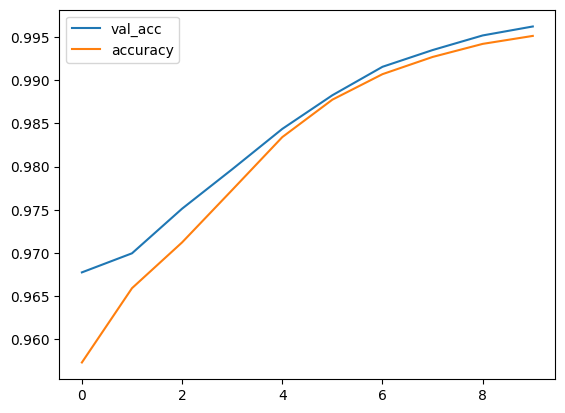

In [84]:
# Plotting the Val Accuracy of the Model

plt.plot(hist.history['val_accuracy'],label = 'val_acc')
plt.plot(hist.history['accuracy'],label = 'accuracy')
plt.legend()

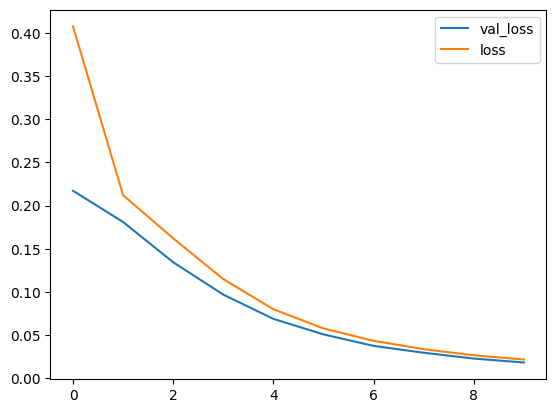

In [85]:
# Plotting the Val Loss matrix

plt.plot(hist.history['val_loss'],label = 'val_loss')
plt.plot(hist.history['loss'],label = 'loss')
plt.legend()

In [86]:
# Saving the Prediction Model
import pickle

pickle.dump(model,open("English_Hindi_Translate.sav",'wb'))

# Creating the Inference model.

In [87]:
# Encoding the imput place holder
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [ ]:
# Decoder for prediction (one input at a time)

decoder_inital_h=Input(shape=(Latent_dim,))  # This initialize the hidden states of LSTM 
decoder_inital_c=Input(shape=(Latent_dim,))  # This initialize the Cell states of LSTM 

decoder_initial_states=[decoder_inital_h,decoder_inital_c] # This initialize the decoder status

decoder_input_single=Input(shape=(1,))       # It will take single input                       
decoder_embedding_single=decoder_embedding(decoder_input_single) # This is embedding the words for finding the relationship between the words. 
decoder_outputs_x,h,c=decoder_lstm(decoder_embedding_single,initial_state=decoder_initial_states) # This give output of LSTM for the current time step , hidden state and cell state

decoder_states=[h,c] # Storing that state

decoder_output=decoder_dense(decoder_outputs_x) # This apply dense layer to the output of the LSTM.

decoder_model=Model([decoder_input_single]  +  decoder_initial_states, 
                    [decoder_output]  +  decoder_states
                   )  # The model takes as input the decoder input token and the initial states, and it outputs the decoder output along with the final states.

In [89]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [90]:
def decode_sequence(sequence):
    states_value=encoder_model.predict(sequence,verbose=0)     # context vector:-will return [h,c]

    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_output['<sos>']    #First input to decoder

    eos=word2idx_output['<eos>']

    output_sequence=[]

    for _ in range(max_seq_len):
        output_token,h,c=decoder_model.predict([target_seq]+states_value,verbose=0)

        idx=np.argmax(output_token[0,0,:])
        
        if idx==eos:                       # if the predicted token is <eos>
            break

        if idx>0:
            output_sequence.append(idx2word_output[idx])

        target_seq[0,0]=idx

        states_value=[h,c]
    
    return ' '.join(output_sequence)


In [91]:
i=0
while i<4:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

------------------
input text: _ Auto complete insert
real output स्वतःपूर्ण
predicted output: स्वतः पूर्ण घुसाएँ
------------------
input text: Rows
real output पंक्तियां
predicted output: पंक्तियां
------------------
input text: Add _ Package
real output जोड़ें पैकेज
predicted output: जोड़ें पैकेज
------------------
input text: ten of clubs
real output चिड़ी का दहला
predicted output: चिड़ी का दहला
